In [74]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
from matplotlib import offsetbox
from sklearn import manifold

### Restore pre-trained Convnet model

In [2]:
sess = tf.Session()

In [3]:
saver =  tf.train.import_meta_graph('./tmp/minst_convnet_model.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint('./tmp/'))

INFO:tensorflow:Restoring parameters from ./tmp/minst_convnet_model.ckpt


### Retrieve tensors 

In [31]:
training = sess.graph.get_tensor_by_name('training:0')
x = sess.graph.get_tensor_by_name('Placeholder:0')
y = sess.graph.get_tensor_by_name('Placeholder_1:0')
fc1_relu = sess.graph.get_tensor_by_name('fc1/Relu:0')

### Compute fc1 layer embedding features for MNIST test images

In [29]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
X = mnist.test.images  # Returns np.array
Y = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [32]:
X_fc1_embedding = sess.run(fc1_relu, feed_dict={x: X, training: False})

In [33]:
X_fc1_embedding.shape

(10000, 1024)

In [139]:
sess.close()

### Reduce dimensionality to 2D with T-SNE

In [37]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, verbose=1)
X_tsne = tsne.fit_transform(X_fc1_embedding)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.449s...
[t-SNE] Computed neighbors for 10000 samples in 100.572s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 5.161366
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.020592
[t-SNE] Error after 1000 iterations: 1.542556


In [38]:
X_tsne.shape

(10000, 2)

#### Define plot function

In [34]:
digit_indices = { i:[] for i in range(10)}
for i, digit in enumerate(Y):
    digit_indices[digit].append(i)

In [143]:
def plot_embedding(X, images):
    
    x_min = X.min(0)
    x_max = X.max(0)
    X = (X - x_min) / (x_max - x_min)
    
    plt.figure(figsize=(12,12))
    ax = plt.subplot(111)
    colors = plt.cm.rainbow(np.linspace(0,1,10))    
    
    for d, c in zip(range(10), colors):
        X_d = X[digit_indices[d]]
        plt.scatter(X_d.T[0],X_d.T[1], color=c, label='digit = %d' % d)
    
    shown_images = [[1., 1.]]
    for i in range(images.shape[0]):
        dist = np.min((shown_images - X[i])**2)
        if dist < 2e-5:
            continue
        shown_images = np.r_[shown_images, [X[i]]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(images[i], cmap=plt.cm.gray_r), X[i])        
        ax.add_artist(imagebox)

    plt.legend(bbox_to_anchor=(1,1))    
    plt.show()
    

#### Utility function to downsample image resolution

In [145]:
def downsample_images(images, new_resolution=(8,8), kernel=(3,3)):
    m, orig_width, orig_height = images.shape
    new_width, new_height = new_resolution        
    assert(orig_width >= new_width)
    assert(orig_height >= new_height)    
    new_images = np.zeros((m, new_width, new_height))
    h_scale = orig_width / new_width
    v_scale = orig_height / new_height
        
    for r in range(new_height):
        rr = math.floor(r * v_scale)
        for c in range(new_width):
            cc = math.floor(c * h_scale)            
            for i in range(m):
                pixel_val = 0.
                count = 0
                for h in range(kernel[0]):
                    if cc + h >= orig_width:
                        continue
                    for v in range(kernel[1]):
                        if rr + v >= orig_height:
                            continue
                        pixel_val += images[i,cc+h,rr+v]
                        count += 1
                pixel_val /= count
                new_images[i,c,r] = pixel_val                
    
    return new_images

### Plot Embedding

In [141]:
images_downsampled = downsample_images(X.reshape(-1,28,28), new_resolution=(10,10), kernel=(4,4))

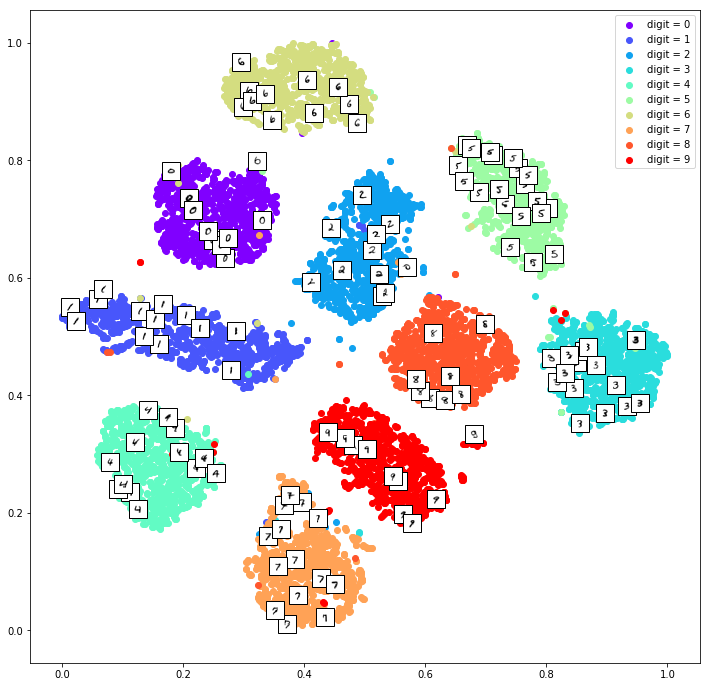

In [144]:
plot_embedding(X_tsne, images_downsampled)